# EM casing response dipole source

In [1]:
import numpy as np
import os
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.utils import line_through_faces
from simpeg import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

from utils import pad_for_casing_and_data

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [3]:
directory_path = "/t40array/lheagy/casing-upscaling"

In [4]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Example usage
ensure_directory_exists(directory_path)

Directory '/t40array/lheagy/casing-upscaling' already exists.


In [5]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
# # conductivities
sigma_air = 1e-4
sigma_back = np.r_[1e-1]
casing_l = 500
sigma_casing = 1e6
mur_casing = np.r_[1, 10, 25, 50, 100, 150, 200]

# # casing geometry
casing_b = 10e-2  
casing_t = 2e-2 #np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = casing_b - casing_t

In [7]:
src_a = -510
src_b = -550
src_dz = src_a - src_b
src_z = np.mean([src_a, src_b]) #np.r_[-100, -250, -400, -495, -500, -550, -600]
print(src_z, src_dz)

-530.0 40


In [8]:
# generate a mesh
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t/16, 
    csx2 = 25, 
    pfx1 = 1.3,
    pfx2 = 1.5, 
    domain_x = 1000, 
    npadx = 10
)

pfz = 1.3
npad_z = 28
csz = 0.5
n_core_extra = 10
ncore_z = int(np.max(np.r_[np.abs(casing_l), np.abs(src_z)]) / csz) + n_core_extra
hz = discretize.utils.unpack_widths(
    [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
)

<Axes: xlabel='x', ylabel='z'>

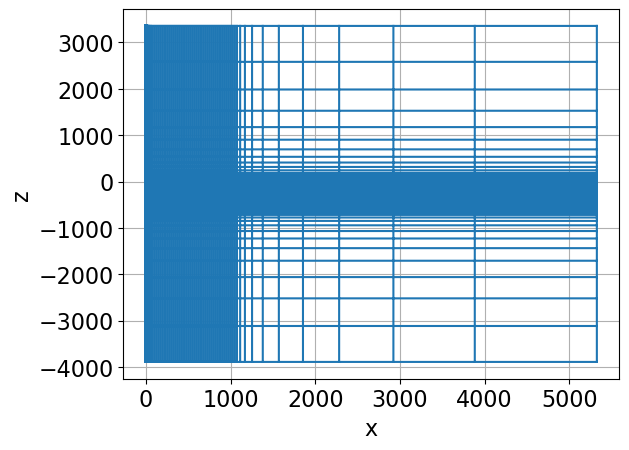

In [9]:
mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz], origin=np.r_[0, 0, -np.sum(hz[:npad_z + int(ncore_z)])],
)

fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)
# ax.set_xlim([0, 5])
# ax.set_ylim(-50, 10)

In [10]:
mesh.n_cells

190294

In [11]:
def get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sigma_casing, sigma_air=1e-4, mur_casing=1):

    model = np.ones(mesh.n_cells)*sigma_air
    model[mesh.cell_centers[:, 2] < 0] = sigma_back

    mur = np.ones(mesh.n_cells)

    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    inds_casing = inds_casing_x & inds_casing_z

    model[inds_casing] = sigma_casing
    mur[inds_casing] = mur_casing

    return model, mur

    

In [12]:
sigma_back

array([0.1])

In [13]:
models = {}
for mur in mur_casing:
    key = f"casing_sig{sigma_casing:1.0e}_mur{mur:1.0f}"
    sig_model, mur_model = get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back[0], sigma_casing, mur_casing=mur)
    models[key] = {
        "sigma": sig_model, 
        "mur": mur_model
    }
keys = list(models.keys())

In [14]:
keys

['casing_sig1e+06_mur1',
 'casing_sig1e+06_mur10',
 'casing_sig1e+06_mur25',
 'casing_sig1e+06_mur50',
 'casing_sig1e+06_mur100',
 'casing_sig1e+06_mur150',
 'casing_sig1e+06_mur200']

In [15]:
def plot_casing(model, xlim=None, zlim=None, vmin=None, vmax=None, ax=None, cb_label=None, logscale=True, show_cb=False): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    if logscale is True: 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    else: 
        pcolor_opts={"norm":Normalize(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    out = mesh.plot_image(
        model, pcolor_opts=pcolor_opts, ax=ax, mirror=True
    )

    if show_cb is True: 
        cb = plt.colorbar(out[-1], shrink=0.5)
        cb.set_label(cb_label)

    if xlim is not None: 
        ax.set_xlim(xlim)
    if zlim is not None: 
        ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax, out

In [16]:
# fig, ax = plt.subplots(1, 2, figsize=(2*4.5, 6.5), dpi=dpi_high, sharey=True)

# xlim = 0.3*np.r_[-1, 1]
# zlim = np.r_[-590, 20]
# vmin = sigma_air
# vmax = sigma_casing

# sigma_map, mu_map = create_maps(key)

# _, out = plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[0])
# _, out = plot_casing(sigma_map * np.r_[np.log(1e5)], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[1])
# # cb.set_label("conductivity (S/m)")

# for i, a in enumerate(ax): 
#     a.plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok", ms=4)
#     a.text(0.01, src_z, "10m dipole", va="center", fontsize=14)
#     for sign in np.r_[-1, 1]: 
#         if i == 0: 
#             a.arrow(
#                 0, -casing_l+120, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#                 head_length=1e-2, head_width=10, color="k"
#             ) 
#             a.text(0, -casing_l+100, f"{casing_a*1e2*2:1.0f} cm", ha="center", fontsize=10)
#             a.text(0.06, -200, "$\sigma$: 5e6 S/m \n$\mu>\mu_0$", fontsize=14)
#         else: 
#             a.text(0.06, -200, "$\sigma$: ? \n$\mu:?$", fontsize=14)
        
#         a.arrow(
#             0, -casing_l+80, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )
#         a.text(0, -casing_l+55, f"{casing_b*1e2*2:1.0f} cm", ha="center", fontsize=10)
#         a.text(-0.29, zlim.min()+10, f"{(1./sigma_back[0]):1.0f} $\Omega$m", fontsize=14)

# ax[1].set_ylabel("")

# ax[0].set_title("(a) true cased well")
# ax[1].set_title("(b) solid cylinder")
    

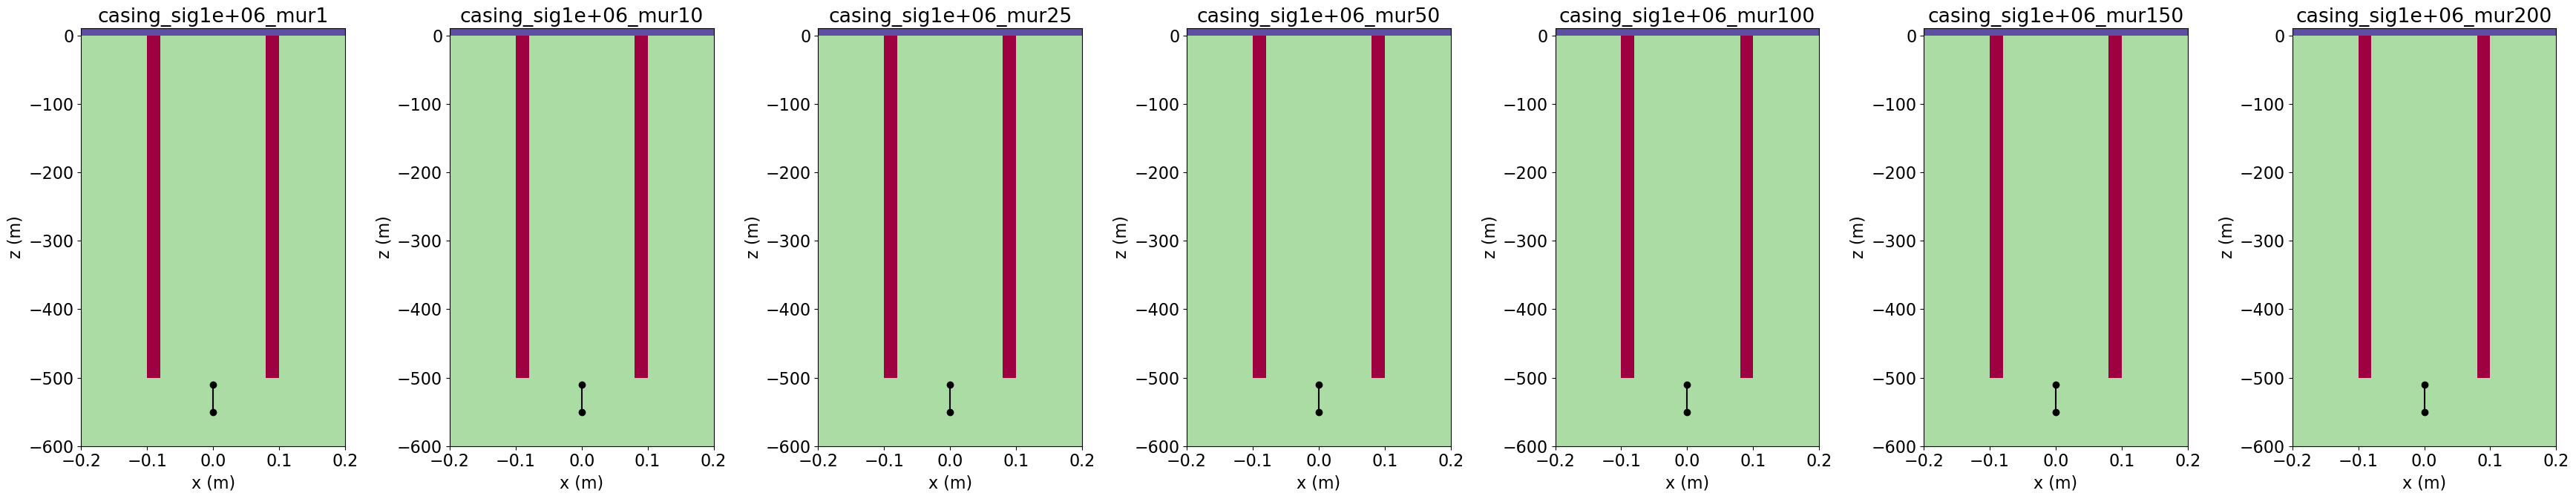

In [17]:
plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 0.2*np.r_[-1, 1]
zlim = np.r_[-600, 10]
vmin = sigma_air
vmax = sigma_casing

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

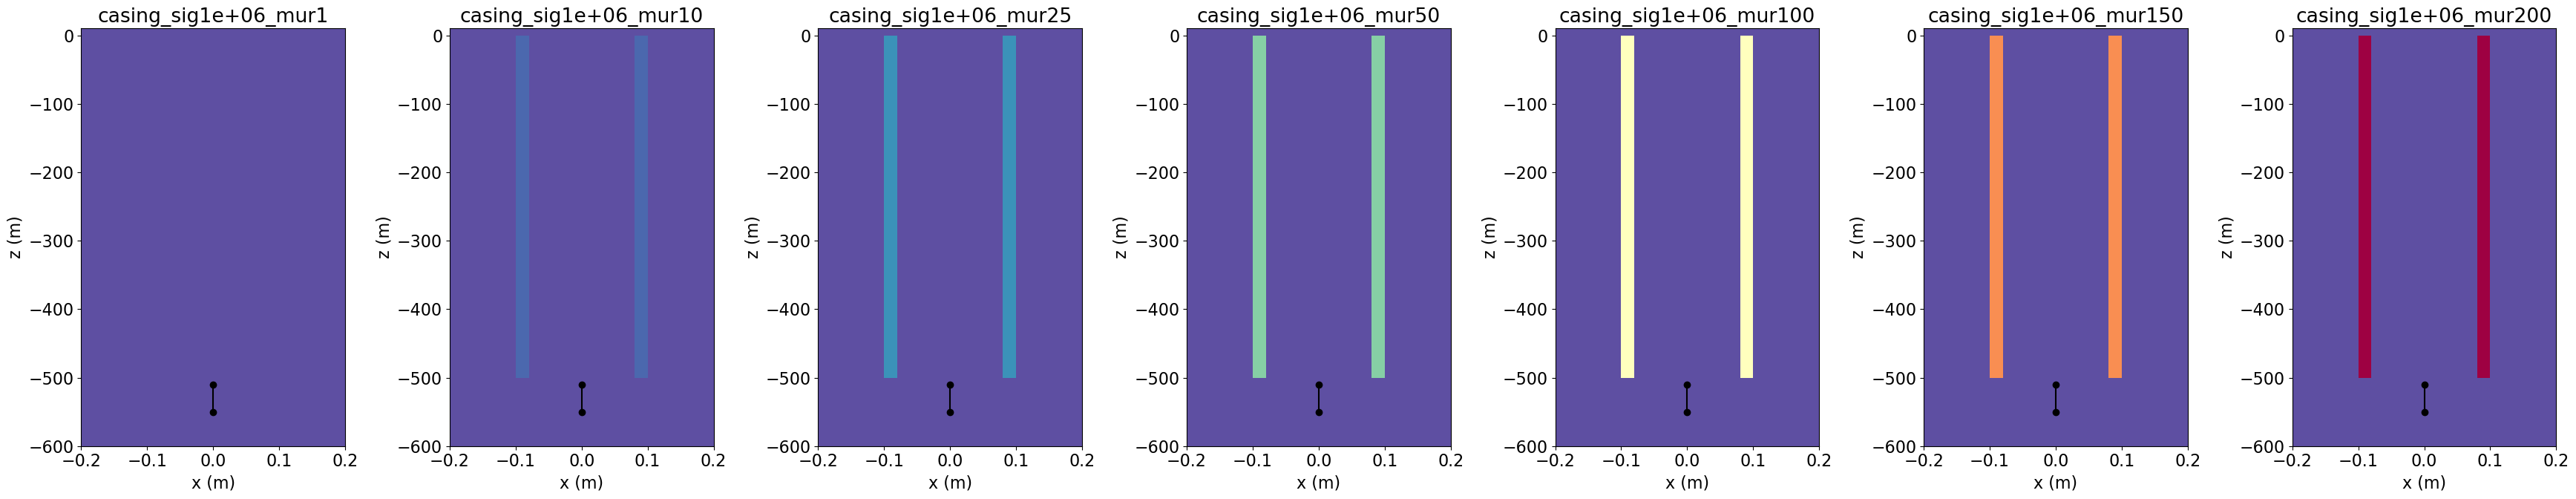

In [18]:
plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 0.2*np.r_[-1, 1]
zlim = np.r_[-600, 10]
vmin = 1
vmax = mur_casing.max()

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["mur"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i], logscale=False)
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [19]:
frequencies = 10**np.linspace(-1, 4, 36)
frequencies = frequencies[:1]
frequencies

array([0.1])

In [20]:
src_list = []
src_locations = np.array([
    [0, 0, src_z+src_dz/2.],
    [0, 0, src_z-src_dz/2.]
])
for f in frequencies: 
    src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
    src_list.append(src)

wires = maps.Wires(("sigma", mesh.n_cells), ("mur", mesh.n_cells))
permeability_map = maps.MuRelative(mesh)

survey = fdem.Survey(src_list)

sim = fdem.simulation.Simulation3DMagneticField(
    mesh=mesh, sigmaMap=wires.sigma, muMap=permeability_map * wires.mur,
    survey=survey, solver=Pardiso, #mu=mur * mu_0
#     verbose=True
)

In [21]:
def run_simulation(key):
    
    filename = os.path.sep.join([directory_path, key])

    t = time.time()
    print(f"starting {key}..., saving to {filename}")
    fields = sim.fields(np.r_[models[key]["sigma"], models[key]["mur"]])
    print(f" ... done. {time.time()-t:1.2e} \n")
    
    np.save(filename, fields[:, "hSolution"])

    return fields

In [22]:
fields = {}

In [23]:
for key in keys: 
    if key not in fields: 
        fields[key] = run_simulation(key)

starting casing_sig1e+06_mur1..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur1
 ... done. 1.27e+00 

starting casing_sig1e+06_mur10..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur10
 ... done. 8.70e-01 

starting casing_sig1e+06_mur25..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur25
 ... done. 7.82e-01 

starting casing_sig1e+06_mur50..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur50
 ... done. 8.42e-01 

starting casing_sig1e+06_mur100..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur100
 ... done. 8.17e-01 

starting casing_sig1e+06_mur150..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur150
 ... done. 8.68e-01 

starting casing_sig1e+06_mur200..., saving to /t40array/lheagy/casing-upscaling/casing_sig1e+06_mur200
 ... done. 6.28e-01 



In [24]:
fields

{'casing_sig1e+06_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ff8df0c9250>,
 'casing_sig1e+06_mur10': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ff8def7e010>,
 'casing_sig1e+06_mur25': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ff8df11eb10>,
 'casing_sig1e+06_mur50': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ff8df136b10>,
 'casing_sig1e+06_mur100': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ff8ea281210>,
 'casing_sig1e+06_mur150': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ffabc502090>,
 'casing_sig1e+06_mur200': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7ffabe6cb610>}

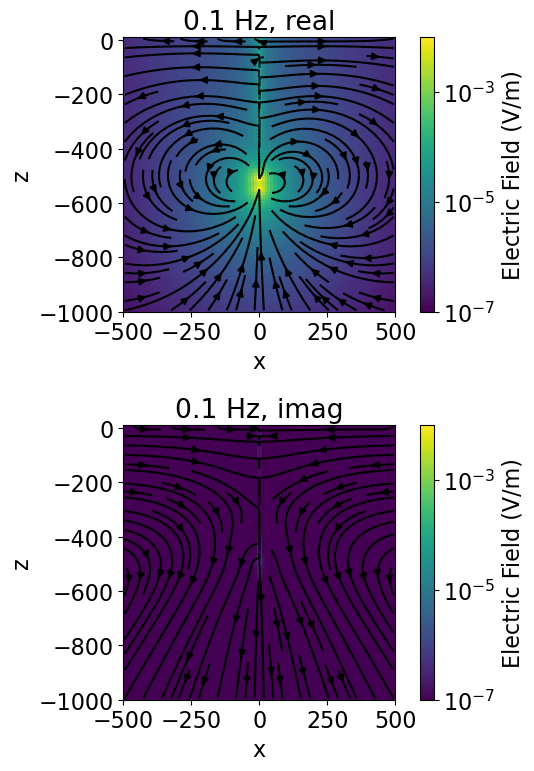

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

key = keys[0]
freq_ind = 0
xlim = 500*np.r_[-1, 1]
zlim = np.r_[-1000, 10]

field_plot = (mesh.average_face_to_cell_vector * fields[key][fields[key].simulation.survey.source_list[freq_ind], "e"])

for i, component in enumerate(["real", "imag"]): 
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        sample_grid = np.r_[10, 10],
        mirror=True, #mirror_data=field_mirror,
        ax=ax[i], 
        pcolor_opts={"norm":LogNorm(vmin=1e-7, vmax=1e-2)}
    )
    # ax[i].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
    cb = plt.colorbar(out[0], ax=ax[i])
    cb.set_label("Electric Field (V/m)")
    ax[i].set_aspect(1)
    ax[i].set_title(f"{frequencies[freq_ind]} Hz, {component}")
plt.tight_layout()

In [26]:
# def load_fields(name, conductivity, mur):
#     solution = np.load(f"{directory}/fields_{name}.npy")
#     sim = generate_simulation(mur)
#     sim.model = conductivity
#     f = sim.fieldsPair(sim)
#     f[:, sim._solutionType] = solution
#     return f

# choose models to focus on

In [27]:
len(frequencies)

1

In [28]:
# casing_t_inv = np.r_[5e-3]
# mur_inv = np.r_[1, 50, 100, 150, 200]
# freq_inds_inv = np.arange(0, 31, 1)
# src_ind_inv = 5

# inv_keys = []
# for t in casing_t_inv:
#     for mur in mur_inv:
#         inv_keys.append(f"casing_{mur}_{t:1.2e}")
# inv_keys

In [29]:
# frequencies[freq_inds_inv]

In [30]:
# fields = {}
# for key in inv_keys:
#     # if key not in fields.keys():
#     fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

In [31]:
rcParams["font.size"] = 12

In [32]:
fields.keys()

dict_keys(['casing_sig1e+06_mur1', 'casing_sig1e+06_mur10', 'casing_sig1e+06_mur25', 'casing_sig1e+06_mur50', 'casing_sig1e+06_mur100', 'casing_sig1e+06_mur150', 'casing_sig1e+06_mur200'])

In [33]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [34]:
rx_x = np.linspace(25, 500, 20)
rx_z = -np.linspace(0, 600, 25) - csz/2
rx_z

array([-2.5000e-01, -2.5250e+01, -5.0250e+01, -7.5250e+01, -1.0025e+02,
       -1.2525e+02, -1.5025e+02, -1.7525e+02, -2.0025e+02, -2.2525e+02,
       -2.5025e+02, -2.7525e+02, -3.0025e+02, -3.2525e+02, -3.5025e+02,
       -3.7525e+02, -4.0025e+02, -4.2525e+02, -4.5025e+02, -4.7525e+02,
       -5.0025e+02, -5.2525e+02, -5.5025e+02, -5.7525e+02, -6.0025e+02])

In [35]:
def create_receivers():
    rx_ex_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_ex_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    rx_ez_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="real",
    )
    rx_ez_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="imag",
    )
    return rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im

In [36]:
rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
Px = rx_ex_re.getP(mesh, "Fx")
Pz = rx_ez_re.getP(mesh, "Fz")

In [37]:
frequencies

array([0.1])

In [38]:
range(len(frequencies))

range(0, 1)

In [39]:
# get data_vectors
dobs_dict = {}

for k in keys:
    tmp_dict = {}
    for si in range(len(frequencies)):
        src = sim.survey.source_list[si]
        e = fields[k][src, "e"]
        edatax = (Px * e).squeeze()
        edataz = (Pz * e).squeeze()
        tmp_dict[frequencies[si]] = {
            "real_x": edatax.real,
            "imag_x": edatax.imag,
            "real_z": edataz.real,
            "imag_z": edataz.imag
        }
    dobs_dict[k] = tmp_dict
        

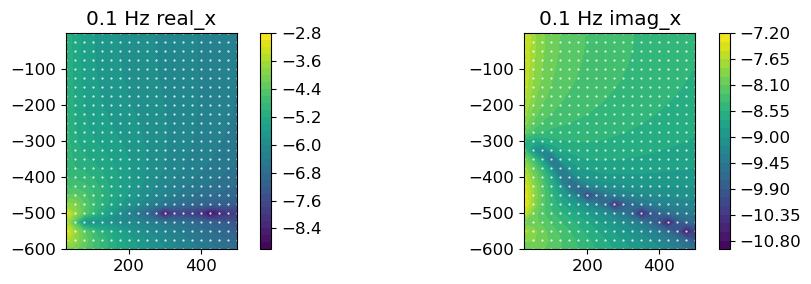

In [40]:
fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

ax=np.atleast_2d(ax)

key_ind = 0
key = keys[key_ind]

for i, freq in enumerate(frequencies): 
    # ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
    for j, component in enumerate(["real_x", "imag_x"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_z, np.log10(np.abs(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T)), 30,
                # vmin=-7, vmax=-2
                # norm=LogNorm()
            ), ax=ax[i, j]
        )
        
        ax[i, j].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
        ax[i, j].set_aspect(1)
        ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [41]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

In [42]:
# fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

# key_ind = 0
# key = keys[key_ind]

# for i, freq in enumerate(frequencies): 
#     amp, phase = get_amplitude_phase(*(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T for component in ["real", "imag"]))
#     for j, plotme in enumerate([np.log10(np.abs(amp)), phase]): 
#         plt.colorbar(
#             ax[i, j].contourf(
#                 rx_x, rx_z, plotme, 30,
#                 # vmin=-7, vmax=-2
#                 # norm=LogNorm()
#                 cmap = "twilight" if j == 1 else "viridis"
#             ), ax=ax[i, j]
#         )
        
#         ax[i, j].plot(rx_e_re.locations[:, 0], rx_e_re.locations[:, 2], "w.", ms=1)
#         ax[i, j].set_aspect(1)
#         ax[i, j].set_title(f"{freq} Hz {'amplitude' if j==0 else 'phase'}")

# plt.tight_layout()


# set up mappings and simulation

In [43]:
def create_maps(key, true_inds=False, casing_t_ind=0):
    indsx = (mesh.cell_centers[:, 0] < casing_b)
    if true_inds is True: 
        indsx = indsx & (mesh.cell_centers[:, 0] > casing_b - casing_t[casing_t_ind])
    
    inds_interior = (
        indsx &
        (mesh.cell_centers[:, 2] <= 0) &
        (mesh.cell_centers[:, 2] >= -casing_l)
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[key]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[key]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [44]:
src_locations

array([[   0.,    0., -510.],
       [   0.,    0., -550.]])

In [45]:
def create_survey(freq, components=["x"]): 
    rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
    rx_list = []
    if "x" in components: 
        rx_list.append([rx_ex_re, rx_ex_im])
    if "z" in components: 
        rx_list.append([rx_ez_re, rx_ez_im])
    src = fdem.sources.LineCurrent(list(np.hstack(rx_list)), location=src_locations, frequency=freq)
    return fdem.Survey([src])

In [46]:
# create the simulation
def create_simulation(key, survey, invert_mu=False, true_inds=False):
    sigma_map, mu_map = create_maps(key, true_inds)

    if invert_mu is True: 
        wires = maps.Wires(("sigma", 1), ("mu", 1))
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


In [47]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)

data0 = {}
res0 = {}
rms0 = {}

components = ["x", "z"]

for i, key in enumerate(keys): 
    data_tmp = {}
    res_tmp = {}
    rms_tmp = {}
    
    for freq in frequencies: 
        survey = create_survey(freq, components)
    
        receivers = []
        if "x" in components: 
            receivers.append(["real_x", "imag_x"])
        if "z" in components: 
            receivers.append(["real_z", "imag_z"])
        dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    
        sim = create_simulation(key, survey, invert_mu=False)
        dpred = sim.dpred(np.log(sigdc))

        data_tmp[freq] = dpred
        res_tmp[freq] = dpred - dobsvec
        rms_tmp[freq] = np.sqrt(np.sum(res_tmp[freq]**2) / len(res_tmp[freq]))
    data0[key] = data_tmp
    res0[key] = res_tmp
    rms0[key] = rms_tmp

In [48]:
from string import ascii_lowercase

In [49]:
sigdc

360000.0000000001

In [50]:
plot_inds = [2, 3, 4, 5, 6]

In [51]:
# # freqs = frequencies[[7, 12, 14]]
# freqs = frequencies[[0]]
# fig, ax = plt.subplots(3, len(freqs), figsize=(4.7*len(freqs), 7), sharex=True, dpi=dpi_high)

# ax=np.atleast_2d(ax)
# if len(freqs) == 1: 
#     ax = ax.T
# for j, freq in enumerate(freqs):
#     plotind = 0
#     for i, key in enumerate(keys): 
#         if i in plot_inds:
#             if i == 0:
#                 color = "k"
#             else: 
#                 color = f"C{plotind}"
#                 plotind = plotind + 1
#             dobs = dobs_dict[key][freq]["real_x"][:len(rx_x)]
#             d0 = data0[key][freq][:len(rx_x)]
#             ax[0, j].semilogy(rx_x, (dobs), color=color, label=f"{mur_casing[i]:1.0f}$\mu_0$")
#             ax[0, j].semilogy(rx_x, (d0), f"--{color}")
#             ax[1, j].semilogy(rx_x, np.abs(d0-dobs), color)
#             ax[2, j].semilogy(rx_x, np.abs(d0-dobs)/np.abs(dobs)*100, color)
    
#             # ax[0, j].set_title(f"{freq:1.0f} Hz\n({ascii_lowercase[j]})")
    
#             ax[0, j].set_ylim([2e-7, 5e-6])
#             ax[1, j].set_ylim([3e-10, 1e-6])
#             ax[2, j].set_ylim([5e-2, 1e2])

# ax[0, 0].set_xlim([0, 400])
# ax[0, 0].set_ylabel("E$_x$ real (V/m)")
# ax[1, 0].set_ylabel("difference (V/m)")
# ax[2, 0].set_ylabel("difference (%)")

# ax[0, 0].legend(loc=1)

# ax[0, 0].set_title("(a) 2 Hz real E$_x$")
# ax[0, 1].set_title("(b) 10 Hz real E$_x$")

# ax[1, 0].set_title("(c) 2 Hz difference (cylinder - hollow)")
# ax[1, 1].set_title("(d) 10 Hz difference (cylinder - hollow)")

# ax[2, 0].set_title("(e) 2 Hz difference (%)")
# ax[2, 1].set_title("(f) 10 Hz difference (%)")

# for k, a in enumerate(ax.flatten()):
#     a.grid()
# #     if k > 1: 
# #         a.set_title(f"({ascii_lowercase[k]})")

# for a in ax[2, :].flatten():
#     a.set_xlabel("x (m)")

# for a in ax[:, 1:].flatten():
#     a.set_yticklabels("")
    

# plt.tight_layout()

In [52]:
rx_x[1]

50.0

100.0


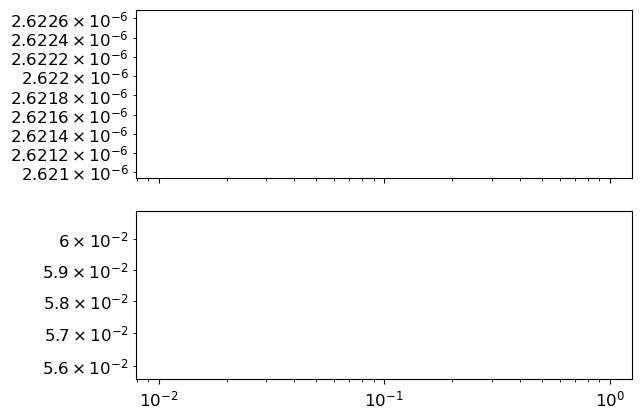

In [53]:
fig, ax = plt.subplots(2, 1, sharex=True)

rx_ind = 3
max_freq_ind = 18
print(rx_x[rx_ind])
for i, key in enumerate(keys): 
    dobs = np.hstack([dobs_dict[key][freq]["real_x"][rx_ind] for freq in frequencies[:max_freq_ind]])
    d0 = np.hstack([data0[key][freq][rx_ind] for freq in frequencies[:max_freq_ind]])
    ax[0].loglog(frequencies[:max_freq_ind], np.abs(dobs), color=f"C{i}", label=key)
    ax[0].loglog(frequencies[:max_freq_ind], np.abs(d0), f"--C{i}")
    # ax[0].loglog(frequencies[:max_freq_ind], np.abs(d0-dobs), f":C{i}")
    ax[1].loglog(frequencies[:max_freq_ind], np.abs(d0-dobs)/np.abs(dobs)*100, f"C{i}")

# set up inversions

In [54]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            "mur":[],
            "residual":[],
            "rms":[],
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        self.inversion_results["mur"].append(self.invProb.model[1])

        dobs = self.invProb._dmisfit.objfcts[0].data.dobs
        
        self.inversion_results["residual"].append((dobs - self.invProb.dpred))
        self.inversion_results["rms"].append(np.sqrt(np.sum(self.inversion_results["residual"][-1]**2)/len(dobs)))
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [238]:
def create_inversion(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    maxIter=20, maxIterCG=50, maxIterLS=20, true_casing_inds=False, components=["x"],
    chifact=0.5
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 0], upper=np.r_[np.log(100*sigma_casing), np.inf],
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
    
    else: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=chifact)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

# experiment 2: invert for solid cylinder conductivity, permeability 

In [239]:
def create_misfit(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    true_casing_inds=False, components=["x", "z"]
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    return dmis
    # def dmis_func(x):
    #     f = sim.fields(x)
    #     return np.r_[dmis(x, f=f)], dmis.deriv(x, f=f)

    # return dmis_func  


In [240]:
misfit_dict = {}
relative_error = 0
noise_floor=1e-9

for key in keys:
    if key not in misfit_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_misfit(
                    key, freq, invert_mu=True, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"]
                )
        misfit_dict[key] = tmp

In [241]:
np.log(sigma_casing)

13.815510557964274

In [242]:
logsigmas = np.linspace(12, 18, 50)
rel_permeabilities = np.linspace(1, 250, 50)

tmpsig = np.kron(logsigmas, np.ones_like(rel_permeabilities))
tmpmu = np.kron(np.ones_like(logsigmas), rel_permeabilities)

model_matrix = np.c_[tmpsig, tmpmu]
freqs = frequencies[[0]]
#frequencies[::7]
# tmp
freqs

array([0.1])

In [243]:
freqs

array([0.1])

In [244]:
# %%time
# objfctvals = {}

# objfct_keys = [keys[4]]
# for key in objfct_keys:
#     objfctvals_tmp = {}
#     t0 = time.time()
#     for freq in freqs:  
        
#         phi = misfit_dict[key][freq]
#         objfctvals_tmp[freq]  = np.hstack([phi(model_matrix[i, :]) for i in range(model_matrix.shape[0])])
#         print(f"{key} {freq:1.1e} Hz: {time.time() - t0:1.2f} s")
#     objfctvals[key] = objfctvals_tmp


In [245]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# key = keys[4]
# freq = freqs[1]
# plotme = objfctvals[key][freq].reshape(len(logsigmas), len(rel_permeabilities))

# sig_ind = 8
# mur_ind = 3

# ax[0].set_title(f"$\mu_r: {rel_permeabilities[mur_ind]:1.1f}$")
# ax[1].set_title(f"$\sigma: {np.exp(logsigmas[sig_ind]):1.1e} S/m$")

# ax[0].plot(np.log10(np.exp(logsigmas)), plotme[:, mur_ind])
# ax[1].plot(rel_permeabilities, plotme[sig_ind, :])

# ax[0].set_xlabel("conductivity")
# ax[1].set_xlabel("permeability")

In [246]:
# len(objfctvals['casing_sig5e+06_mur100'].keys())

In [247]:
# fig, ax = plt.subplots(3, 4, figsize=(16, 12))
# key = keys[4]

# ax = ax.flatten()
# for i, freq in enumerate(freqs): 
#     plotme = objfctvals[key][freq].reshape(len(logsigmas), len(rel_permeabilities))
    
#     cb = plt.colorbar(
#         # ax[i].contourf(np.exp(logsigmas), rel_permeabilities, np.log10(plotme.T), 10), 
#         ax[i].contourf(np.log10(np.exp(logsigmas)), rel_permeabilities, np.log10(plotme.T), 20), 
#         ax=ax[i]
#     )
#     cb.set_label("$\phi_d$")

#     ax[i].set_title(f"{freq:1.0e} Hz")
#     ax[i].set_xlabel("$\log_{10}(\sigma)$")
#     ax[i].set_ylabel("$\mu_r$")

# fig.suptitle(f"{key}")
# plt.tight_layout()

In [248]:
sigdc

360000.0000000001

In [249]:
inv_dict = {}
relative_error = 0.0
noise_floor = 1e-9

for i, key in enumerate(keys):
    # if i == 0: 
    #     chifact = 0.5
    # else: 
    chifact = 0.00001
    if key not in inv_dict: 
        tmp = {}
        for freq in frequencies:
            
            tmp[freq] = create_inversion(
                    key, freq, invert_mu=True, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"], chifact=chifact
                )
        inv_dict[key] = tmp

In [250]:
tmp = inv_dict[keys[0]][frequencies[0]]
np.unique(tmp.invProb.dmisfit.objfcts[0].simulation.muMap * np.r_[10, 1])

array([1.25663706e-06])

In [251]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }

In [252]:
keys

['casing_sig1e+06_mur1',
 'casing_sig1e+06_mur10',
 'casing_sig1e+06_mur25',
 'casing_sig1e+06_mur50',
 'casing_sig1e+06_mur100',
 'casing_sig1e+06_mur150',
 'casing_sig1e+06_mur200']

In [253]:
geometric_factor = casing_t / (2*casing_b) * (3 - casing_t / casing_b)

In [255]:
mrec_dict = {}

for i, key in enumerate(keys):
    if key not in mrec_dict: 
        tmp = {}
        for j, freq in enumerate(frequencies):
            print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")
            # if i == 0: 
            mstart = np.r_[np.log(sigdc), mur_casing[i]]
            # else: 
            #     mstart = mrec_dict[keys[0]][freq]
            tmp[freq] = inv_dict[key][freq].run(mstart)
            print(f"recovered conductivity: {np.exp(inv_dict[key][freq].m[0]):1.2e}, recovered permeability: {inv_dict[key][freq].m[1]:1.2f} mu0 \n")
        mrec_dict[key] = tmp



------------------------ casing_sig1e+06_mur1 : 0.1 Hz -------------------------- 


                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticField problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.64e+04  0.00e+00  1.64e+04    1.14e+06      0   Skip BFGS  
   1  0.00e+00  1.46e+04  2.69e-01  1.46e+04    5.63e+00      0   Skip BFGS  
   2  0.00e+00  1.46e+04  2.69e-01  1.46e+04    5.63e+00      0              
   3  0.00e+00  1.46e+04  2.69e-01  1.46e+04    4.74e+02      1   Skip BFGS  
   4  0.00e+00  1.46e+04  2.69e-01  1.46e+04    4.13e+00      0              
   5  0.00e+00  1.4

In [182]:
inv_results = {}

for key in keys:
    if key not in inv_results: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = inv_dict[key][freq].directiveList.dList[1].inversion_results
        inv_results[key] = tmp

In [183]:
tmp = inv_results[keys[0]][frequencies[0]]

In [184]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [185]:
phi_d_final = {}
chifact_final = {}
phid_star = len(rx_x)*len(rx_z)*2

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            phid_tmp[i] = phid[-1]
    phi_d_final[key] = phid_tmp
    chifact_final[key] = phi_d_final[key] / phid_star

In [186]:
phid_min = {}
chifact_min = {}
logsig_min = {}
mur_min = {}
rms_min = {}

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    logsig_tmp = np.ones(len(frequencies)) * np.nan
    mur_tmp = np.ones(len(frequencies)) * np.nan
    rms_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            ind_min = np.argmin(phid)
            phid_tmp[i] = phid[ind_min]
            logsig_tmp[i] = inv_results[key][freq]["logsigma"][ind_min]
            mur_tmp[i] = inv_results[key][freq]["mur"][ind_min]
            rms_tmp[i] = inv_results[key][freq]["rms"][ind_min]
    phid_min[key] = phid_tmp
    logsig_min[key] = logsig_tmp
    mur_min[key] = mur_tmp
    rms_min[key] = rms_tmp

In [187]:
# fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True) 

# for key in keys: 
#     mrec = np.vstack(mrec_dict[key].values())
    
#     ax[0].semilogx(frequencies, phi_d_final[key] / phid_star, "o", label=key)
#     ax[0].semilogx(frequencies,  np.ones_like(frequencies),"--k")
#     ax[1].loglog(frequencies, np.exp(mrec[:, 0]), "o", label=key)
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
#     ax[2].semilogx(frequencies, mrec[:, 1], "o", label=key)

# ax[1].set_ylim([1e6, 1e8])
# # ax[0].legend()

In [188]:
# fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True) 

# for key in keys: 
#     ax[0].loglog(frequencies, phid_min[key], "o", label=key)
#     ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
#     ax[1].loglog(frequencies, np.exp(logsig_min[key]), "o", label=key)
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
#     ax[2].semilogx(frequencies, (mur_min[key]), "o", label=key)
# ax[0].legend()

In [189]:
markers = ["o", "v", "s", "D", "p", "^", "h"]

In [190]:
mur_casing

array([  1,  10,  25,  50, 100, 150, 200])

In [191]:
plotkeys = np.hstack([keys[0], keys[2:]])
plotkeys

array(['casing_sig1e+06_mur1', 'casing_sig1e+06_mur25',
       'casing_sig1e+06_mur50', 'casing_sig1e+06_mur100',
       'casing_sig1e+06_mur150', 'casing_sig1e+06_mur200'], dtype='<U22')

In [192]:
def mur_by_skindepth(delta):
    omega = 2 * np.pi * frequencies
    return 2 / (omega * delta**2 * sigma_casing) / mu_0

In [193]:
mur_by_skindepth(casing_t)/mu_0

array([5.03930225e+09])

In [194]:
# plt.plot(np.vstack(mrec_dict[keys[0]].values())[:, 0])
# plt.plot(logsig_min[keys[0]])


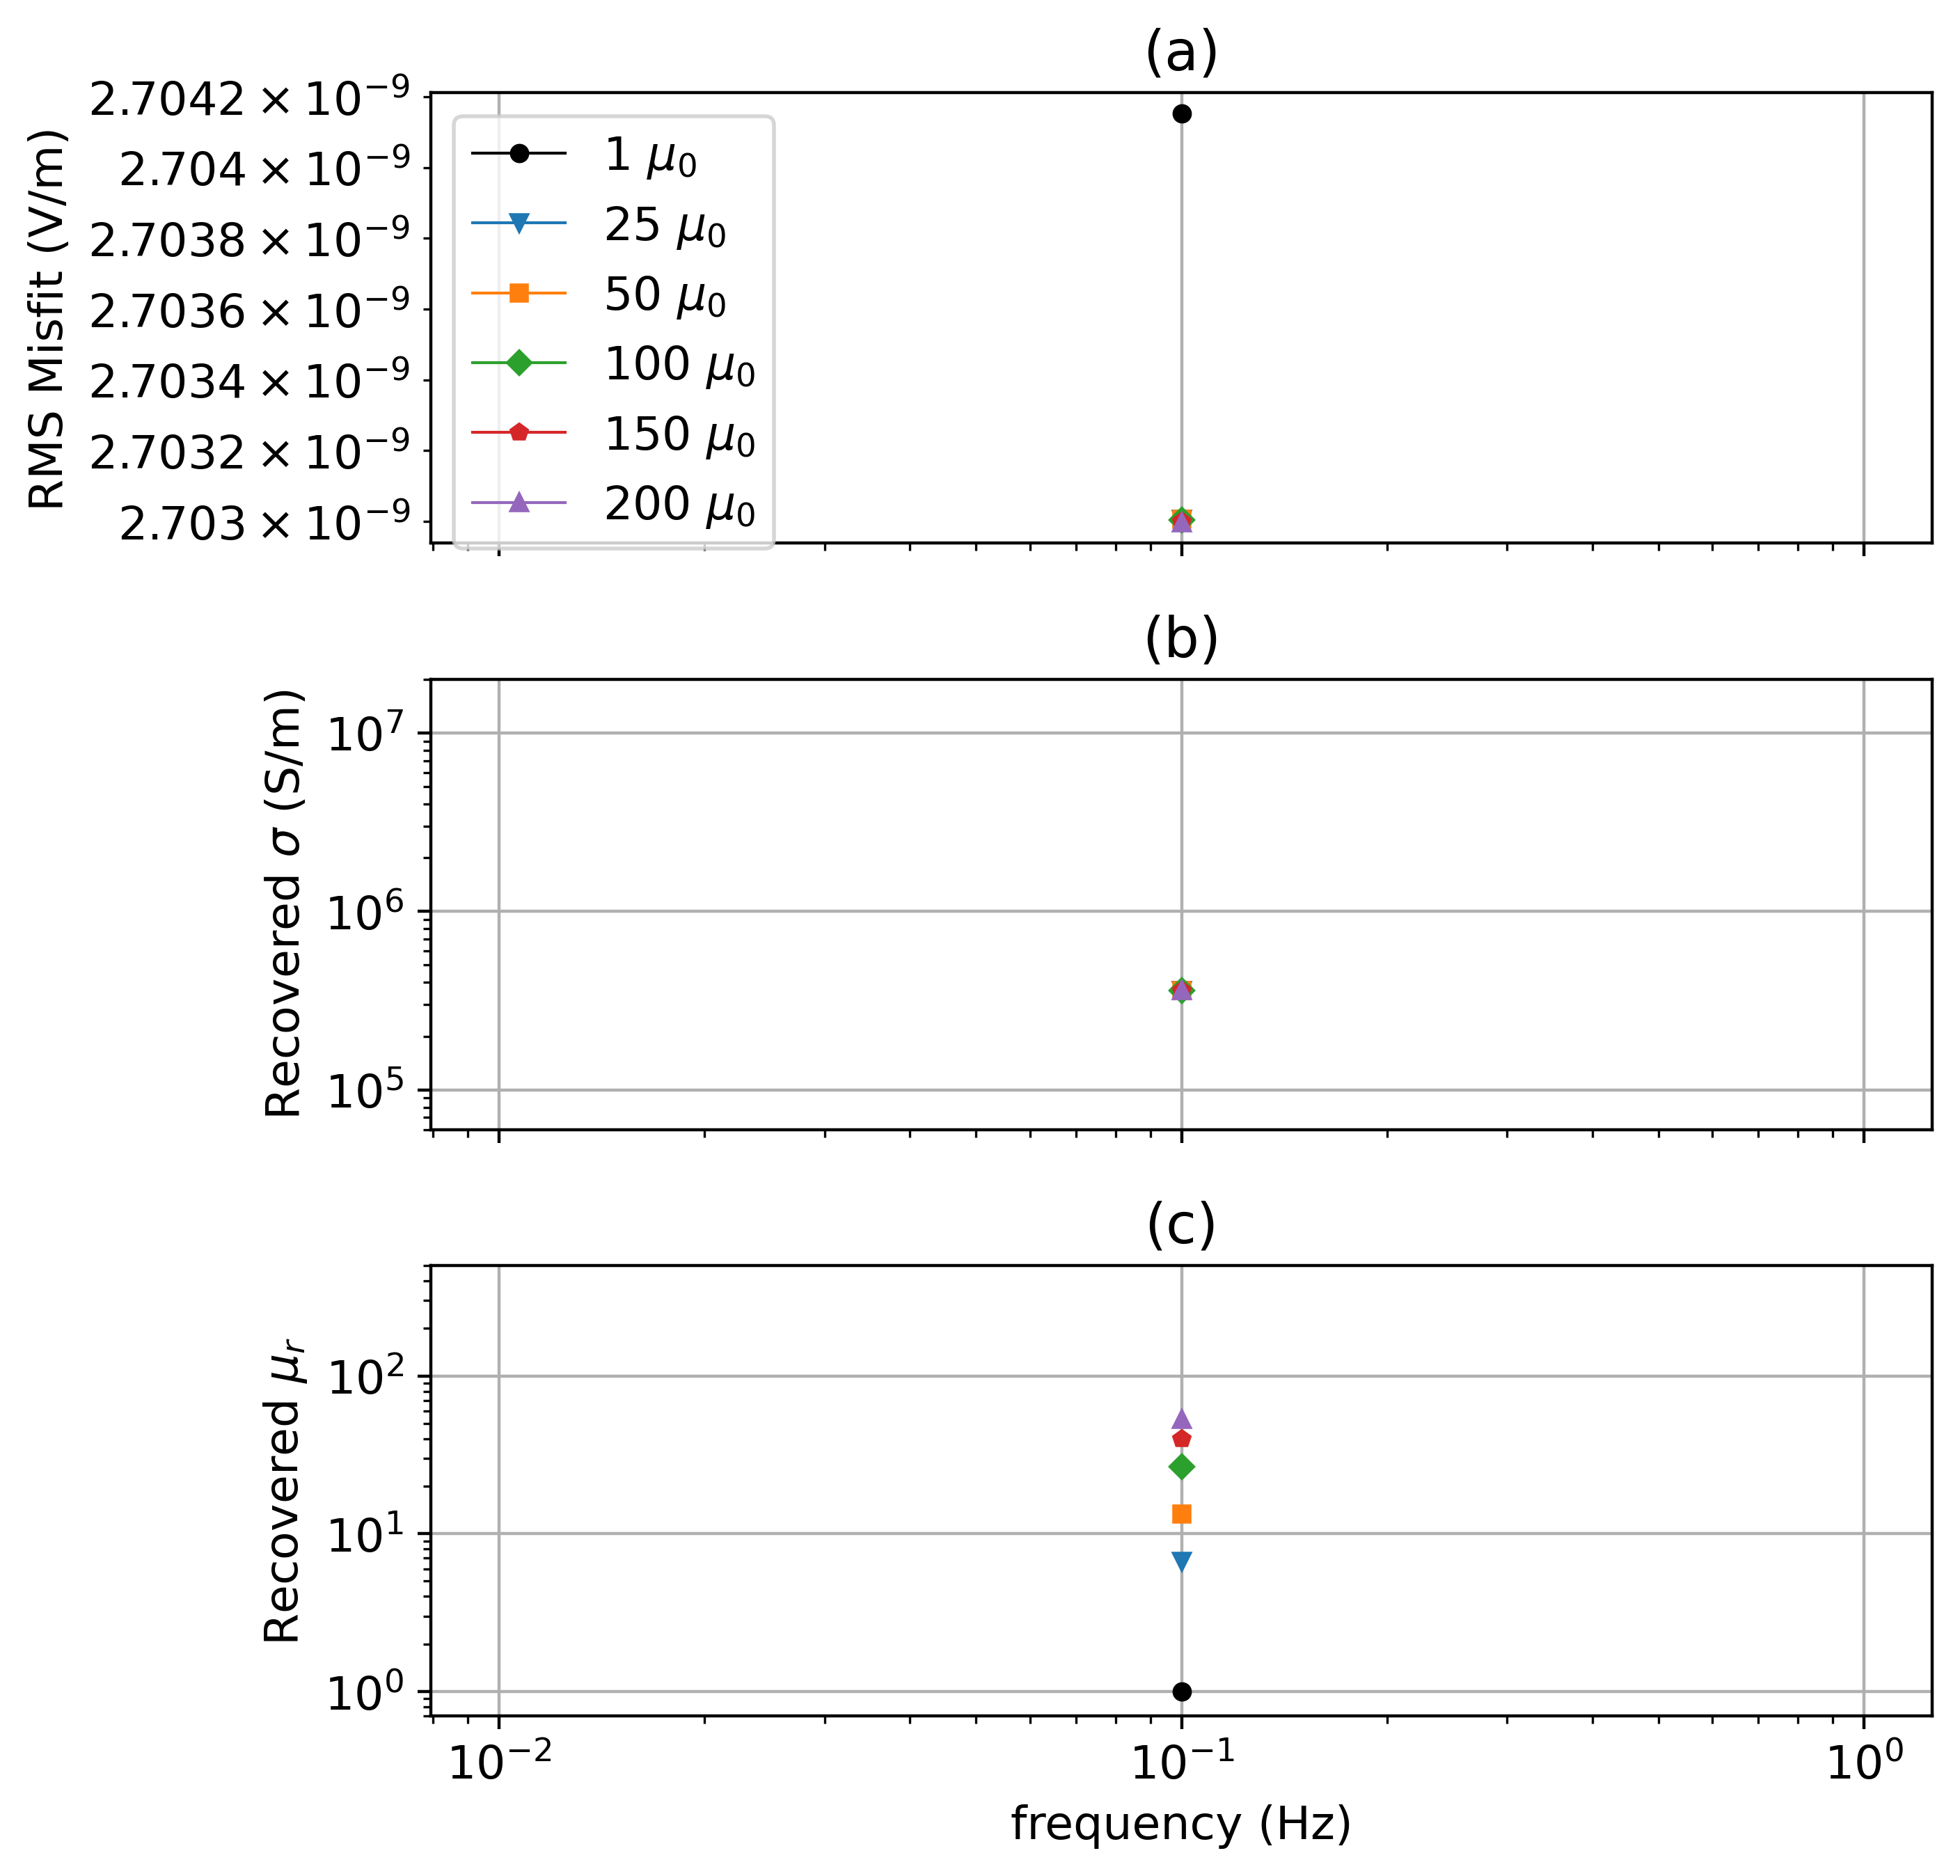

In [195]:
fig, ax = plt.subplots(3, 1, figsize=(7.2, 6.9), sharex=True, dpi=dpi_high) 

for i, key in enumerate(plotkeys): 
    color = "k" if i==0 else f"C{i-1}"
    label = f"{key.split('_')[-1][3:]} $\mu_0$"
    ax[0].loglog(frequencies, rms_min[key], f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    # ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(logsig_min[key]), f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
    ax[2].loglog(frequencies, (mur_min[key]), f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    
for a in ax:
    a.grid()
    
ax[0].legend(loc=2)
ax[1].set_ylim(6e4, 2e7)
ax[2].set_ylim([0.7, 500])

# ax[2].text(1.1e3, 2, "$\delta\sim t/2$", alpha=0.7)
# ax[2].loglog(frequencies, mur_by_skindepth(casing_t/2), ":k", alpha=0.6)

# ax[2].text(2e1, 2, "$\delta\sim 1.3 t$", alpha=0.7)
# ax[2].loglog(frequencies, mur_by_skindepth(1.3*casing_t), ":k", alpha=0.6)

ax[0].set_ylabel("RMS Misfit (V/m)")
ax[1].set_ylabel("Recovered $\sigma$ (S/m)")
ax[2].set_ylabel("Recovered $\mu_r$")
ax[2].set_xlabel("frequency (Hz)")

ax[0].set_title("(a)")
ax[1].set_title("(b)")
ax[2].set_title("(c)")

plt.tight_layout()

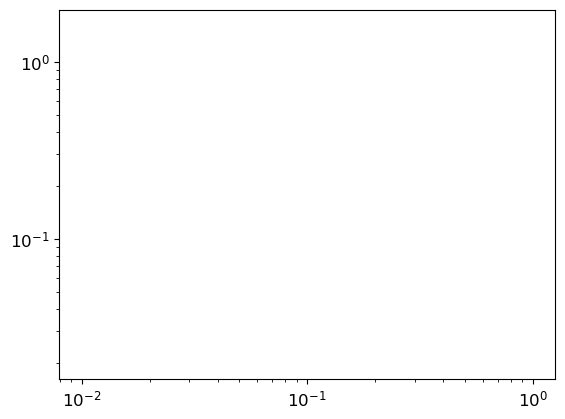

In [196]:
skin_depths_casing = 500/np.sqrt(sigma_casing * frequencies) 

fig, ax = plt.subplots(1, 1) 
ax.loglog(frequencies, skin_depths_casing)
ax.loglog(frequencies, np.ones_like(frequencies)*casing_t, "--k")
ax.loglog(frequencies, np.ones_like(frequencies)*csz, ":k")

In [197]:
from scipy import stats

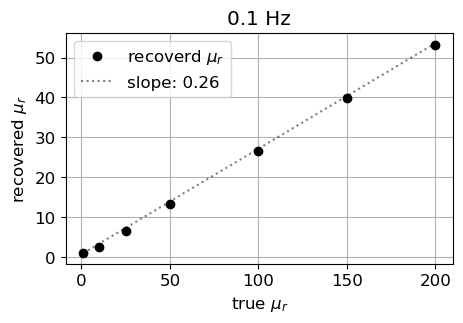

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

freq_ind = 0

mur_1Hz =  np.array([mur_min[k][freq_ind] for k in plot_keys])
mur_true = np.array([np.float64(k.split('_')[-1][3:]) for k in plot_keys])

slope, intercept, r, p, std_err = stats.linregress(mur_true-1, mur_1Hz-1)

ax.plot(mur_true, mur_1Hz, "ko", label="recoverd $\mu_r$")
    
ax.plot(mur_true, slope*(mur_true-1)+1, ":k", alpha=0.5, label=f"slope: {slope:1.2f}")
ax.set_xlabel("true $\mu_r$")
ax.set_ylabel("recovered $\mu_r$")
ax.set_title(f"{frequencies[freq_ind]} Hz")
ax.grid("both")
# ax.set_aspect(1)
ax.legend()
    # ax.plot()

In [199]:
(slope * casing_b / casing_t)

1.3209740286127203

In [200]:
(casing_b**2 - casing_a**2)/casing_b**2 

0.3600000000000001

In [201]:
fields_rec = {}

for key in keys:
    tmp_fields = {}
    for i, freq in enumerate(frequencies):
        tmp_fields[freq] = inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.fields(np.r_[logsig_min[key][i], mur_min[key][i]])
 
    fields_rec[key] = tmp_fields

In [202]:
def plot_fields(
    field_plot, freq_ind=0, xlim=500*np.r_[-1, 1], zlim=np.r_[-1000, 10], component="real", ax=None, vmin=None, vmax=None, aspect=True,
    plot_source=False
):
    if ax is None: 
        fig, ax = plt.subplots(1,1)

    if len(field_plot) == mesh.n_faces: 
        field_plot = mesh.average_face_to_cell_vector * np.squeeze(field_plot)
        
        out = mesh.plot_image(
            getattr(field_plot, component), "CCv", view="vec", 
            range_x = xlim, range_y = zlim,
            sample_grid = np.r_[np.diff(xlim)/100, np.diff(zlim)/100],
            mirror=True, #mirror_data=field_mirror,
            ax=ax, 
            pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
            stream_threshold=vmin
        )

    elif len(field_plot) == mesh.n_edges: 
        field_plot = mesh.average_edge_to_cell_vector * np.squeeze(field_plot)
        
        out = mesh.plot_image(
            getattr(field_plot, component), "CC",  
            range_x = xlim, range_y = zlim,
            mirror=True, mirror_data=-1*field_plot,
            ax=ax, 
            pcolor_opts={
                "norm":SymLogNorm(linthresh=vmin if vmin is not None else 1e-12, vmin=-1*vmax if vmax is not None else None, vmax=vmax),
                "cmap":"RdBu_r",
            },
            stream_threshold=vmin
        )

    if plot_source is True: 
        ax.plot(src_locations[:, 0], src_locations[:, 2], "w", lw=2)
    
    cb = plt.colorbar(out[0], ax=ax)
    # cb.set_label("Electric Field (V/m)")
    if aspect is True:
        ax.set_aspect(1)

    return out, cb

In [203]:
x_data = mesh.nodes_x[31]
data_locs = np.hstack([mesh.faces_x[:, 0] == x_data, np.zeros(mesh.n_faces_z, dtype=bool)])
np.sum(data_locs)

1126

In [204]:
keys

['casing_sig1e+06_mur1',
 'casing_sig1e+06_mur10',
 'casing_sig1e+06_mur25',
 'casing_sig1e+06_mur50',
 'casing_sig1e+06_mur100',
 'casing_sig1e+06_mur150',
 'casing_sig1e+06_mur200']

In [205]:
# fig, ax = plt.subplots(2, 3, figsize=(12, 10))

# key = keys[4]
# freq_ind = 18

# aspect = False
# xlim = 0.08*np.r_[0, 1]
# zlim = np.r_[-550, 0] 
# plot_source = True
# vmin=1e-8
# vmax=1e1

# true_fields = fields[key]
# fields_true = true_fields[true_fields.simulation.survey.source_list[freq_ind], "j"]
# plot_fields(fields_true, component="real", ax=ax[0, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_true, component="imag", ax=ax[1, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# ax[0, 0].set_title("Real, Hollow")
# ax[1, 0].set_title("Imag, Hollow")


# fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
# plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# ax[0, 1].set_title("Real, Solid")
# ax[1, 1].set_title("Imag, Solid")

# for i, component in enumerate(["real", "imag"]):
#     ax[i, 2].semilogx(np.abs(getattr(fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="hollow")
#     ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="solid")
#     ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs] - fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="difference")
#     ax[i, 2].set_ylim(zlim)
#     ax[i, 2].set_xlim(np.r_[vmin, vmax*1e-2])
#     ax[i, 2].grid()
#     ax[i, 2].set_title(f"j$_x$ {component} at {x_data:1.2f}m")
#     ax[i, 2].set_xlabel("j$_x$ (A/m$^2$)")

# ax[0, 2].legend(loc=1)
# fig.suptitle(f"{key.split('_')[1][3:]}S/m, {key.split('_')[-1][3:]} $\mu_0$, {frequencies[freq_ind]:1.1e} Hz, rms: {rms_min[key][freq_ind]:1.1e} V/m")

# # fields_diff = fields_true - fields_pred
# # plot_fields(fields_diff, component="real", ax=ax[0, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# # plot_fields(fields_diff, component="imag", ax=ax[1, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)


# plt.tight_layout()

In [206]:
mesh

In [207]:
src_locations

array([[   0.,    0., -510.],
       [   0.,    0., -550.]])

In [208]:
# dc response 

dc_src_list = [
    dc.sources.Dipole([], location_a=src_locations[0,:], location_b=src_locations[-1,:])
]
dc_survey = dc.Survey(dc_src_list)
dc_sim = dc.simulation.Simulation3DCellCentered(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=dc_survey, solver=Pardiso, bc_type="Dirichlet",
#     verbose=True
)

In [209]:
hollow_wells = {}
solid_wells = {}

for i, key in enumerate(keys): 
    sig_solid = np.exp(logsig_min[keys[i]][0])
    mur_solid = mur_min[keys[i]][0]
    
    hollow_well = get_physical_property_model(
        mesh, casing_a, casing_b, casing_l, sigma_back=sigma_back, sigma_casing=sigma_casing, sigma_air=1e-4, mur_casing=mur_casing[i]
    )
    hollow_wells[key] = {
        "sigma": hollow_well[0],
        "mur": hollow_well[1]
    }
    
    solid_well = get_physical_property_model(
        mesh, 0, casing_b, casing_l, sigma_back=sigma_back, sigma_casing=sig_solid, sigma_air=1e-4, mur_casing=mur_solid
    )

    solid_wells[key] = {
        "sigma": solid_well[0],
        "mur": solid_well[1]
    }

In [210]:
dc_fields_hollow = dc_sim.fields(models[keys[key_ind]]["sigma"])
dc_fields_solid = dc_sim.fields(solid_wells[keys[0]]["sigma"])

In [211]:
def getAmmr(mur):
    vol = mesh.cell_volumes
    Div = discretize.utils.sdiag(vol) * mesh.face_divergence
    MeMuI = mesh.get_edge_inner_product(mur * mu_0, invert_matrix=True)
    mui = 1./(mur*mu_0)
    return (
        mesh.edge_curl
        * MeMuI
        * mesh.edge_curl.T.tocsr()
        - Div.T.tocsr()
        * discretize.utils.sdiag(1.0 / vol * mui)
        * Div  # stabalizing term. See (Chen, Haber & Oldenburg 2002)
    )

In [212]:
dc_src = dc_src_list[0]

In [213]:
js_dc = line_through_faces(
    mesh, dc_src.location, normalize_by_area=True
)

In [214]:
def solve_mmr(mur, dc_fields):
    Ammr = getAmmr(mur)
    Ammr_inv = Pardiso(Ammr)
    rhs = js_dc + dc_fields[:, "j"].flatten()
    mmr_a = Ammr_inv * rhs
    
    MeMuI = mesh.get_edge_inner_product(mur * mu_0, invert_matrix=True)
    b_mmr = mesh.edge_curl.T * mmr_a
    h_mmr = MeMuI * b_mmr

    return {
        "a": mmr_a, 
        "b": b_mmr, 
        "h": h_mmr
    }


    

In [215]:
mmr_hollow = {}
mmr_solid = {}

for key in keys:
    mmr_hollow[key] = solve_mmr(hollow_wells[key]["mur"], dc_fields_hollow)
    mmr_solid[key] = solve_mmr(solid_wells[key]["mur"], dc_fields_solid)
    

In [216]:
plot_inds = mesh.edges[:, 0] == mesh.nodes_x[np.argmin(np.abs(mesh.nodes_x - casing_b)) - 1]

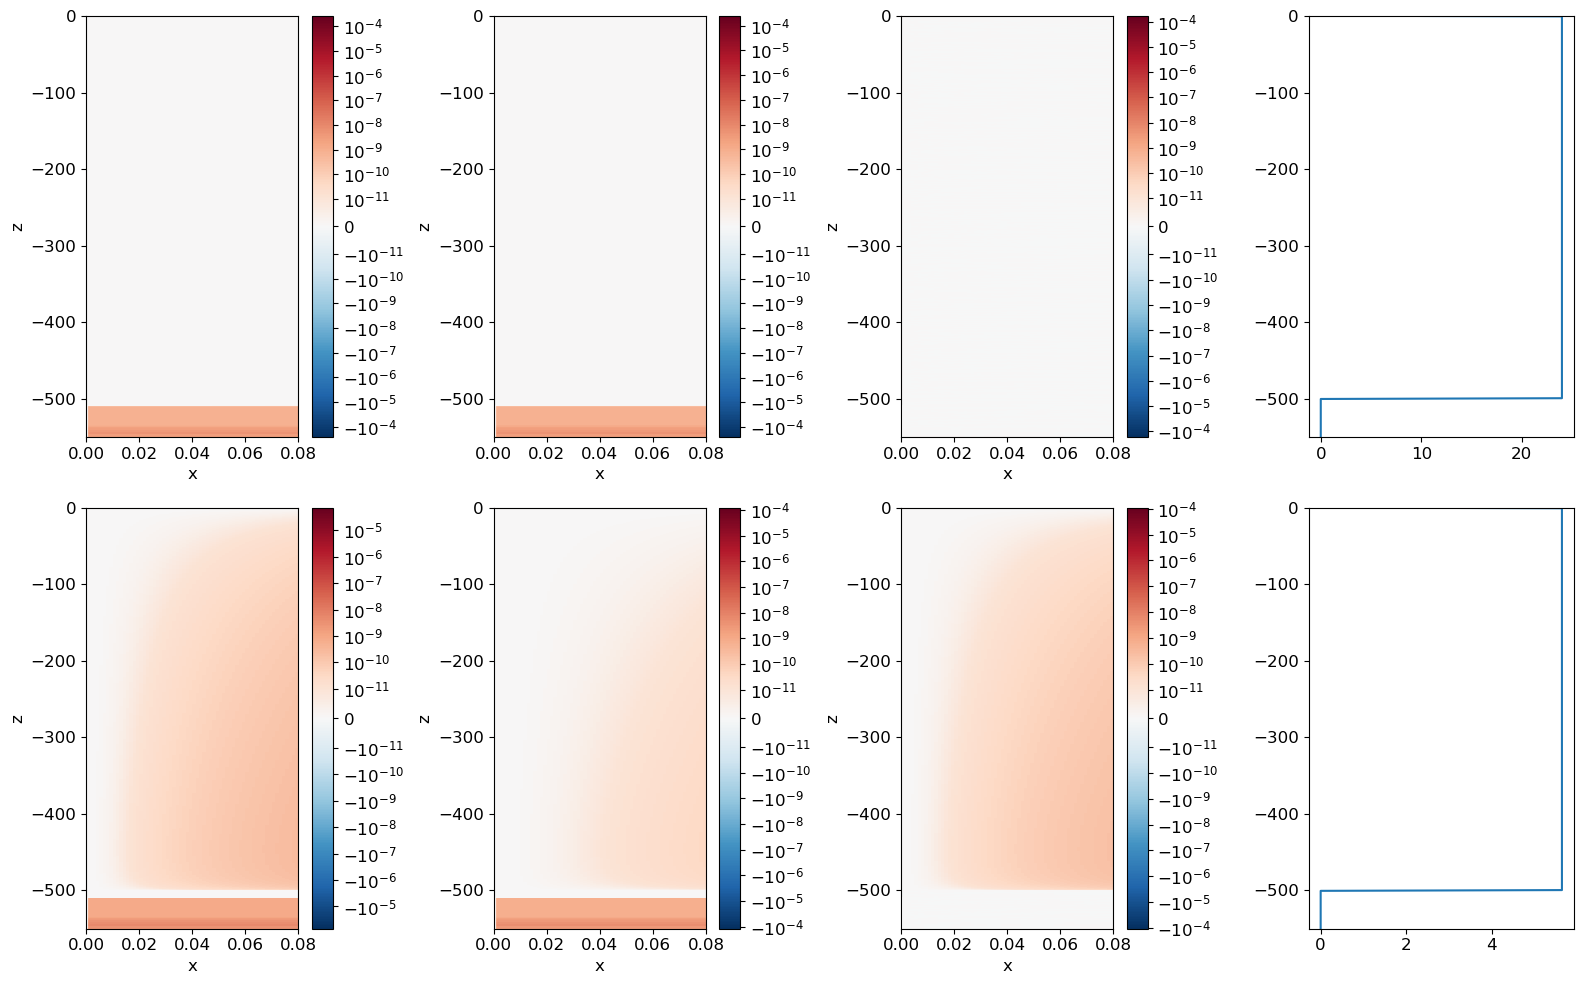

In [217]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))

key = keys[2]

aspect = False
xlim = 0.08*np.r_[0, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-11
# vmax=1e1

for j, solution in enumerate([mmr_hollow, mmr_solid]): 
    plot_fields(solution[key]["b"], component="real", ax=ax[j, 0], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source) 
    plot_fields(solution[keys[0]]["b"], component="real", ax=ax[j, 1], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
    plot_fields(solution[key]["b"] - solution[keys[0]]["b"], component="real", ax=ax[j, 2], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
    
    ax[j, 3].plot(((solution[key]["b"] - solution[keys[0]]["b"])/solution[keys[0]]["b"])[plot_inds], mesh.nodes_z)
    ax[j, 3].set_ylim(zlim)

# fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
# plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# ax[0, 1].set_title("Real, Solid")
# ax[1, 1].set_title("Imag, Solid")


plt.tight_layout()

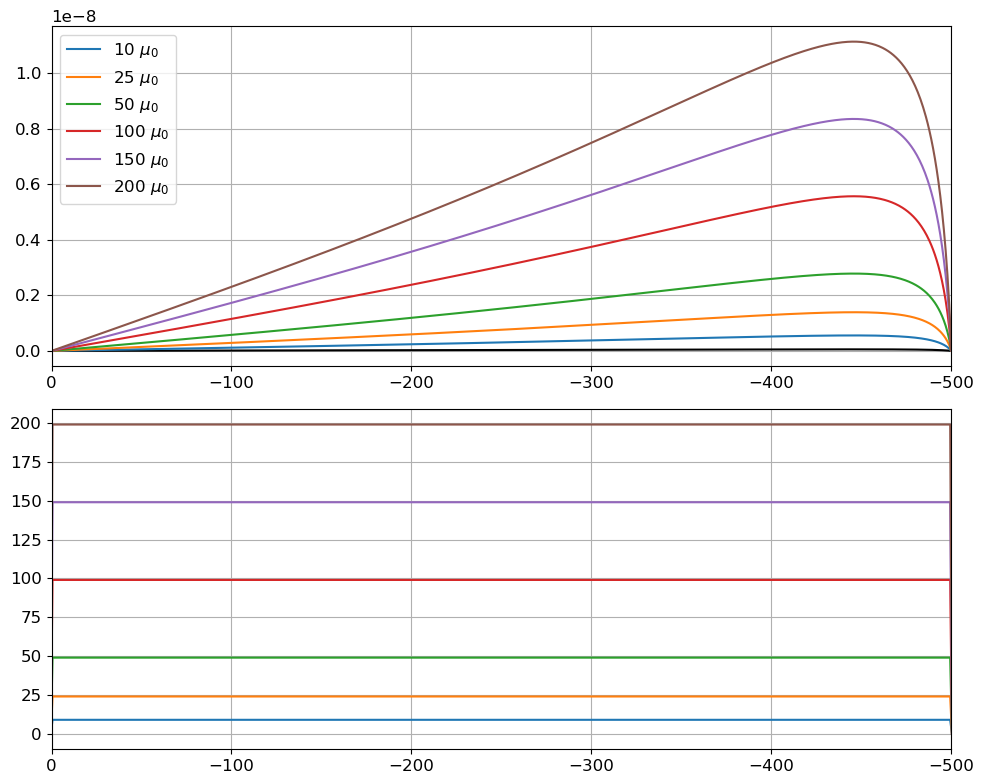

In [218]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

xlim = np.r_[0, -casing_l]

solution = mmr_hollow

ax[0].plot(mesh.nodes_z, solution[keys[0]]["b"][plot_inds], color="k")

for i, key in enumerate(keys[1:]):
    ax[0].plot(mesh.nodes_z, solution[key]["b"][plot_inds], label=f"{key.split('_')[2][3:]} $\mu_0$", color=f"C{i}")
    # ax[0].plot(mesh.nodes_z, mur_casing[i+1]*b_mmr[keys[0]][plot_inds], label=f"{key.split('_')[2][3:]} $\mu_0$", color=f"C{i}", ls="--")
    ax[1].plot(mesh.nodes_z, ((solution[key]["b"]-solution[keys[0]]["b"])/solution[keys[0]]["b"])[plot_inds], label=key)

ax[0].legend()
for a in ax:
    a.set_xlim(xlim)
    a.grid()
# ax[0].set_ylim(-1e-8, 3e-8)
plt.tight_layout()

In [219]:
mur_static = np.array([mur_min[k][0] for k in keys])
mur_static

array([ 1.        ,  2.65856726,  6.64533545, 13.29092299, 26.58008764,
       39.86948473, 53.15939895])

In [220]:
mur_casing/mur_static

array([1.        , 3.76142449, 3.76203732, 3.76196597, 3.76221483,
       3.76227586, 3.76226978])

In [221]:
mur_static / mur_casing

array([1.        , 0.26585673, 0.26581342, 0.26581846, 0.26580088,
       0.26579656, 0.26579699])

In [222]:
# geometric_factor = (1/(2*casing_t)) * (
#     2*casing_b - 3*casing_a 
#     + casing_a**3 / casing_b**2
# )

geometric_factor = casing_t / (2*casing_b) * (3 - casing_t / casing_b)
geometric_factor

0.27999999999999997

In [223]:
casing_t / casing_b

0.19999999999999998

In [224]:
mur_static

array([ 1.        ,  2.65856726,  6.64533545, 13.29092299, 26.58008764,
       39.86948473, 53.15939895])

In [229]:
(mur_casing)* geometric_factor

array([ 0.28,  2.8 ,  7.  , 14.  , 28.  , 42.  , 56.  ])

In [226]:
# 1 - casing_a**2 / casing_b**2

In [227]:
(mur_static - 1) / (mur_casing - 1)

/tmp/ipykernel_3878591/68933915.py:1: RuntimeWarning: invalid value encountered in divide
  (mur_static - 1) / (mur_casing - 1)


array([       nan, 0.18428525, 0.23522231, 0.25083516, 0.25838472,
       0.26086903, 0.26210753])

In [114]:
for i, key in enumerate(keys[1:]):  
    hollow_sol = ((mmr_hollow[key]["b"]-mmr_hollow[keys[0]]["b"])/mmr_hollow[keys[0]]["b"])[plot_inds]
    solid_sol = ((mmr_solid[key]["b"]-mmr_solid[keys[0]]["b"])/mmr_solid[keys[0]]["b"])[plot_inds]
    print(f"{key:25s}: {hollow_sol.max():6.2f}, {solid_sol.max():6.2f}, {hollow_sol.max()/solid_sol.max():6.2f}")

casing_sig1e+06_mur10    :   9.00,   1.66,   5.43
casing_sig1e+06_mur25    :  24.00,   5.65,   4.25
casing_sig1e+06_mur50    :  49.00,  12.29,   3.99
casing_sig1e+06_mur100   :  99.00,  25.58,   3.87
casing_sig1e+06_mur150   : 149.00,  38.87,   3.83
casing_sig1e+06_mur200   : 199.00,  52.16,   3.82


In [115]:
for i, key in enumerate(keys[1:]):  
    hollow_sol = (mmr_hollow[key]["b"])[plot_inds]
    solid_sol = (mmr_solid[key]["b"])[plot_inds]
    print(f"{key:25s}: {hollow_sol.max():1.2e}, {solid_sol.max():1.2e}, {hollow_sol.max()/solid_sol.max():6.2f}")

casing_sig1e+06_mur10    : 5.66e-09, 5.66e-09,   1.00
casing_sig1e+06_mur25    : 5.66e-09, 5.66e-09,   1.00
casing_sig1e+06_mur50    : 5.66e-09, 5.66e-09,   1.00
casing_sig1e+06_mur100   : 5.66e-09, 5.66e-09,   1.00
casing_sig1e+06_mur150   : 8.36e-09, 5.66e-09,   1.48
casing_sig1e+06_mur200   : 1.11e-08, 5.66e-09,   1.97


In [232]:
plot_inds = mesh.edges[:, 2] == mesh.nodes_z[np.argmin(np.abs(mesh.nodes_z - -400))]

(0.0, 0.2)

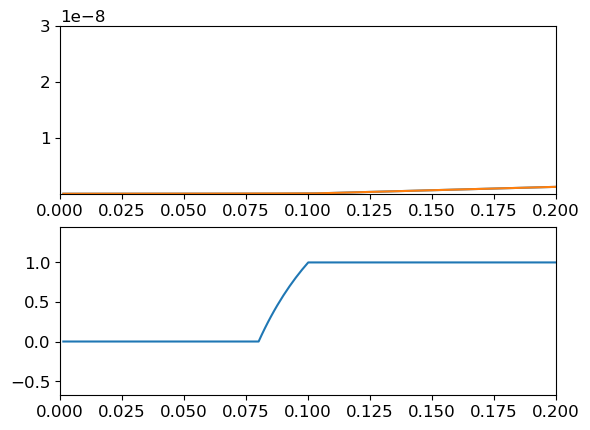

In [233]:
fig, ax = plt.subplots(2, 1) 
key = keys[0]
ax[0].plot(mesh.nodes_x, mmr_hollow[key]["b"][plot_inds])
ax[0].plot(mesh.nodes_x, mmr_solid[key]["b"][plot_inds])
ax[0].set_xlim([0, 0.2])
ax[0].set_ylim(np.r_[1e-11, 3e-8])

ax[1].plot(mesh.nodes_x, mmr_hollow[key]["b"][plot_inds]/mmr_solid[key]["b"][plot_inds])
ax[1].set_xlim([0, 0.2])

(0.0, 0.2)

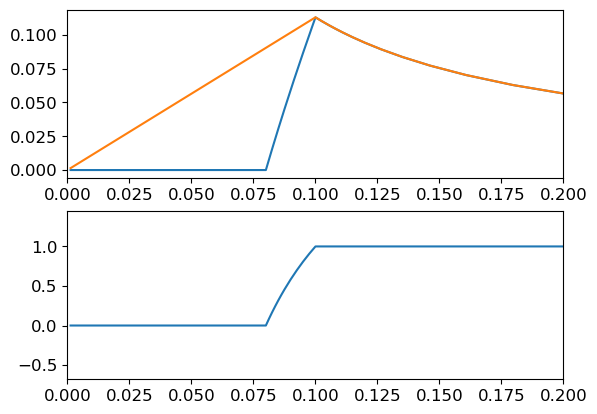

In [234]:
fig, ax = plt.subplots(2, 1) 
key = keys[0]
ax[0].plot(mesh.nodes_x, mmr_hollow[key]["h"][plot_inds])
ax[0].plot(mesh.nodes_x, mmr_solid[key]["h"][plot_inds])
ax[0].set_xlim([0, 0.2])
# ax[0].set_ylim(np.r_[1e-11, 3e-8])

ax[1].plot(mesh.nodes_x, mmr_hollow[key]["h"][plot_inds]/mmr_solid[key]["h"][plot_inds])
ax[1].set_xlim([0, 0.2])

In [235]:
mmr_hollow[key]["h"][plot_inds].max()

0.11292133672689215

In [236]:

max_b_hollow = mmr_hollow[key]["b"][(plot_inds & (mesh.edges[:, 0] <= casing_b))].max()
max_b_solid = mmr_solid[key]["b"][(plot_inds & (mesh.edges[:, 0] <= casing_b))].max()

max_b_hollow, max_b_solid

(5.187887955735829e-11, 5.4359872685485954e-11)

In [237]:
hollow_max_j * np.pi * (casing_b**2 - casing_a**2)

NameError: name 'hollow_max_j' is not defined

In [ ]:
key

In [ ]:
integrate_inds = plot_inds & mesh.edges[:, 0] <= casing_b

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

key = keys[4]

aspect = False
xlim = 0.08*np.r_[0, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-11
# vmax=1e1

plot_fields(dc_fields_hollow[:, "j"], component="real", ax=ax[0], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source) 
plot_fields(dc_fields_solid[:, "j"], component="real", ax=ax[1], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
    
# fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
# plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# ax[0, 1].set_title("Real, Solid")
# ax[1, 1].set_title("Imag, Solid")


plt.tight_layout()

In [ ]:
dc_fields_hollow[:, "j"][mesh.n_faces_x:].shape

In [ ]:
mesh.n_faces_z

In [ ]:
plot_inds_j = mesh.faces_z[:, 2] == mesh.nodes_z[np.argmin(np.abs(mesh.nodes_z - -400))]

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(mesh.cell_centers_x, dc_fields_hollow[:, "j"][mesh.n_faces_x:][plot_inds_j])
ax.plot(mesh.cell_centers_x, dc_fields_solid[:, "j"][mesh.n_faces_x:][plot_inds_j])
ax.set_xlim(np.r_[0, 0.1])

In [ ]:
hollow_max_j = dc_fields_hollow[:, "j"][mesh.n_faces_x:][plot_inds_j].max()
solid_max_j = dc_fields_solid[:, "j"][mesh.n_faces_x:][plot_inds_j].max()
hollow_max_j, solid_max_j, hollow_max_j / solid_max_j

In [ ]:
hollow_max_j * (casing_b**2 - casing_a**2)/casing_b**2

In [ ]:
hollow_max_j * np.pi * (casing_b**2 - casing_a**2)

In [ ]:
solid_max_j * np.pi * casing_b**2

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

key = keys[2]

aspect = False
xlim = 0.08*np.r_[0, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-14
# vmax=1e1

# plot_fields(dc_fields[:, "j"], component="real", ax=ax[0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)

plot_fields(h_mmr[key], component="real", ax=ax[0], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source) 
plot_fields(h_mmr[keys[0]], component="real", ax=ax[1], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(h_mmr[key] - h_mmr[keys[0]], component="real", ax=ax[2], vmin=vmin, vmax=None, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)

ax[3].plot(((h_mmr[key] - h_mmr[keys[0]])/h_mmr[keys[0]])[plot_inds], mesh.nodes_z)
ax[3].set_ylim(zlim)

# fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
# plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# ax[0, 1].set_title("Real, Solid")
# ax[1, 1].set_title("Imag, Solid")


plt.tight_layout()

In [ ]:
np.max(np.abs(h_mmr[key] - h_mmr[keys[0]]))

In [ ]:
mesh.n_cells

In [ ]:
mesh.n_cells*2